# Analysis of Yelp Business Intelligence Data

We will analyze a subset of Yelp's business, reviews and user data. This dataset comes to us from [Kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset) although we have taken steps to pull this data into a publis s3 bucket: `s3://sta9760-yelpdataset/yelp-light/*business.json`

# Installation and Initial Setup

Begin by installing the necessary libraries that you may need to conduct your analysis. At the very least, you must install `pandas` and `matplotlib`

In [2]:
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version
-------------------------- -------
beautifulsoup4             4.8.1
boto                       2.49.0
jmespath                   0.9.4
lxml                       4.4.2
mysqlclient                1.4.6
nltk                       3.4.5
nose                       1.3.4
numpy                      1.14.5
pip                        20.1
py-dateutil                2.2
python36-sagemaker-pyspark 1.2.6
pytz                       2019.3
PyYAML                     3.11
setuptools                 46.1.3
six                        1.13.0
soupsieve                  1.9.5
wheel                      0.34.2
windmill                   1.6

In [3]:
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("seaborn==0.10.1")
sc.install_pypi_package("scipy==1.4.1")
sc.install_pypi_package("numpy==1.18.4")
sc.install_pypi_package("scikit-learn==0.22.2")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached pandas-1.0.3-cp36-cp36m-manylinux1_x86_64.whl (10.0 MB)
  Using cached python_dateutil-2.8.1-py2.py3-none-any.whl (227 kB)

  Using cached matplotlib-3.2.1-cp36-cp36m-manylinux1_x86_64.whl (12.4 MB)
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Using cached kiwisolver-1.2.0-cp36-cp36m-manylinux1_x86_64.whl (88 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)

  Using cached seaborn-0.10.1-py3-none-any.whl (215 kB)
  Using cached scipy-1.4.1-cp36-cp36m-manylinux1_x86_64.whl (26.1 MB)


  Using cached numpy-1.18.4-cp36-cp36m-manylinux1_x86_64.whl (20.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.14.5
    Not uninstalling numpy at /usr/local/lib64/python3.6/site-packages, outside environment /tmp/1588979705509-0
    Can't uninstall 'numpy'. No files were found to uninstall.

  Using cached scikit_learn-0.22.2-cp36-cp36m-manylinux1_x86_64.whl (7.1 MB)
  Using cached joblib-0.14.1-py2.py3-none-any.whl (294 kB)







In [4]:
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version
-------------------------- -------
beautifulsoup4             4.8.1
boto                       2.49.0
cycler                     0.10.0
jmespath                   0.9.4
joblib                     0.14.1
kiwisolver                 1.2.0
lxml                       4.4.2
matplotlib                 3.2.1
mysqlclient                1.4.6
nltk                       3.4.5
nose                       1.3.4
numpy                      1.18.4
pandas                     1.0.3
pip                        20.1
py-dateutil                2.2
pyparsing                  2.4.7
python-dateutil            2.8.1
python36-sagemaker-pyspark 1.2.6
pytz                       2019.3
PyYAML                     3.11
scikit-learn               0.22.2
scipy                      1.4.1
seaborn                    0.10.1
setuptools                 46.1.3
six                        1.13.0
soupsieve                  1.9.5
wheel                      0.34.2
windmill                   1.6

## Importing

Now, import the installed packages from the previous block below.

In [5]:
import pandas as pd, matplotlib as mpl, matplotlib.pyplot as plt, seaborn as sb, numpy as np, seaborn as sns, scipy.stats as st
from pyspark.sql.functions import *
from sklearn import ensemble, tree, linear_model
from scipy import stats
from scipy.stats import norm, skew

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Loading Data

We are finally ready to load data. Using `spark` load the data from S3 into a `dataframe` object that we can manipulate further down in our analysis.

In [6]:
df = spark.read.json("s3://10yelpdata/*s.json")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Overview of Data

Display the number of rows and columns in our dataset.

In [7]:
print(f'Columns:{len(df.columns)} | Rows:{df.count():,}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Columns:14 | Rows:209,393

Display the DataFrame schema below.

In [14]:
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

Display the first 5 rows with the following columns:

* `business_id`
* `name`
* `city`
* `state`
* `categories`

In [9]:
df.createOrReplaceTempView("business")
bus = spark.sql('select business_id,name,city,state,stars,categories from business limit 5')
bus.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------------+-----+-----+--------------------+
|         business_id|                name|           city|state|stars|          categories|
+--------------------+--------------------+---------------+-----+-----+--------------------+
|f9NumwFMBDn751xgF...|The Range At Lake...|      Cornelius|   NC|  3.5|Active Life, Gun/...|
|Yzvjg0SayhoZgCljU...|   Carlos Santo, NMD|     Scottsdale|   AZ|  5.0|Health & Medical,...|
|XNoUzKckATkOD1hP6...|             Felinus|       Montreal|   QC|  5.0|Pets, Pet Service...|
|6OAZjbxqM5ol29BuH...|Nevada House of Hose|North Las Vegas|   NV|  2.5|Hardware Stores, ...|
|51M2Kk903DFYI6gnB...|USE MY GUY SERVIC...|           Mesa|   AZ|  4.5|Home Services, Pl...|
+--------------------+--------------------+---------------+-----+-----+--------------------+

# Analyzing Categories

Let's now answer this question: **how many unique categories are represented in this dataset?**

Essentially, we have the categories per business as a list - this is useful to quickly see what each business might be represented as but it is difficult to easily answer questions such as:

* How many businesses are categorized as `Active Life`, for instance
* What are the top 20 most popular categories available?

## Association Table

We need to "break out" these categories from the business ids? One common approach to take is to build an association table mapping a single business id multiple times to each distinct category.

For instance, given the following:


| business_id | categories |
|-------------|------------|
| abcd123     | a,b,c      |

We would like to derive something like:

| business_id | category |
|-------------|------------|
| abcd123     | a          |
| abcd123     | b          |
| abcd123     | c          |


What this does is allow us to then perform a myriad of rollups and other analysis on this association table which can aid us in answering the questions asked above.

Implement the code necessary to derive the table described from your original yelp dataframe.

Display the first 5 rows of your association table below.

In [13]:
x1 = df.select(col("business_id"), explode(split(col("categories"), ",")).alias('categories'))
x1=x1.withColumn('categories', ltrim(x1.categories))
x1.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------------+
|         business_id|      categories|
+--------------------+----------------+
|f9NumwFMBDn751xgF...|     Active Life|
|f9NumwFMBDn751xgF...|Gun/Rifle Ranges|
|f9NumwFMBDn751xgF...|     Guns & Ammo|
|f9NumwFMBDn751xgF...|        Shopping|
|Yzvjg0SayhoZgCljU...|Health & Medical|
+--------------------+----------------+
only showing top 5 rows

## Total Unique Categories

Finally, we are ready to answer the question: **what is the total number of unique categories available?**

Below, implement the code necessary to calculate this figure.

In [11]:
count = spark.sql(
'''
Select Distinct(category) From category
''')
count.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1336

## Top Categories By Business

Now let's find the top categories in this dataset by rolling up categories.

### Counts of Businesses / Category

So now, let's unroll our distinct count a bit and display the per count value of businesses per category.

The expected output should be:

| category | count |
|-------------|------------|
| a     | 15         |
| b     | 2          |
| c     | 45          |

Or something to that effect.

In [14]:

x1.select('categories').groupby(x1.categories).count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----+
|         categories|count|
+-------------------+-----+
|     Dermatologists|  341|
|   Historical Tours|   54|
|Mobile Home Dealers|   16|
|     Paddleboarding|   36|
|   Hot Air Balloons|   21|
|       Aerial Tours|   28|
|      Skating Rinks|  104|
|  Signature Cuisine|    1|
|             Fondue|   54|
|      Data Recovery|  195|
|  Pet Waste Removal|   34|
|      Videographers|  169|
|    Pet Photography|   49|
|        Boat Repair|  100|
|            Beaches|   74|
|       Contract Law|   13|
|        Hobby Shops|  828|
|           Day Spas| 2880|
|              Reiki|  312|
|           Honduran|    8|
+-------------------+-----+
only showing top 20 rows

### Bar Chart of Top Categories

With this data available, let us now build a barchart of the top 20 categories. 

**HINT**: don't forget about the matplotlib magic!

```
%matplot plt
```

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

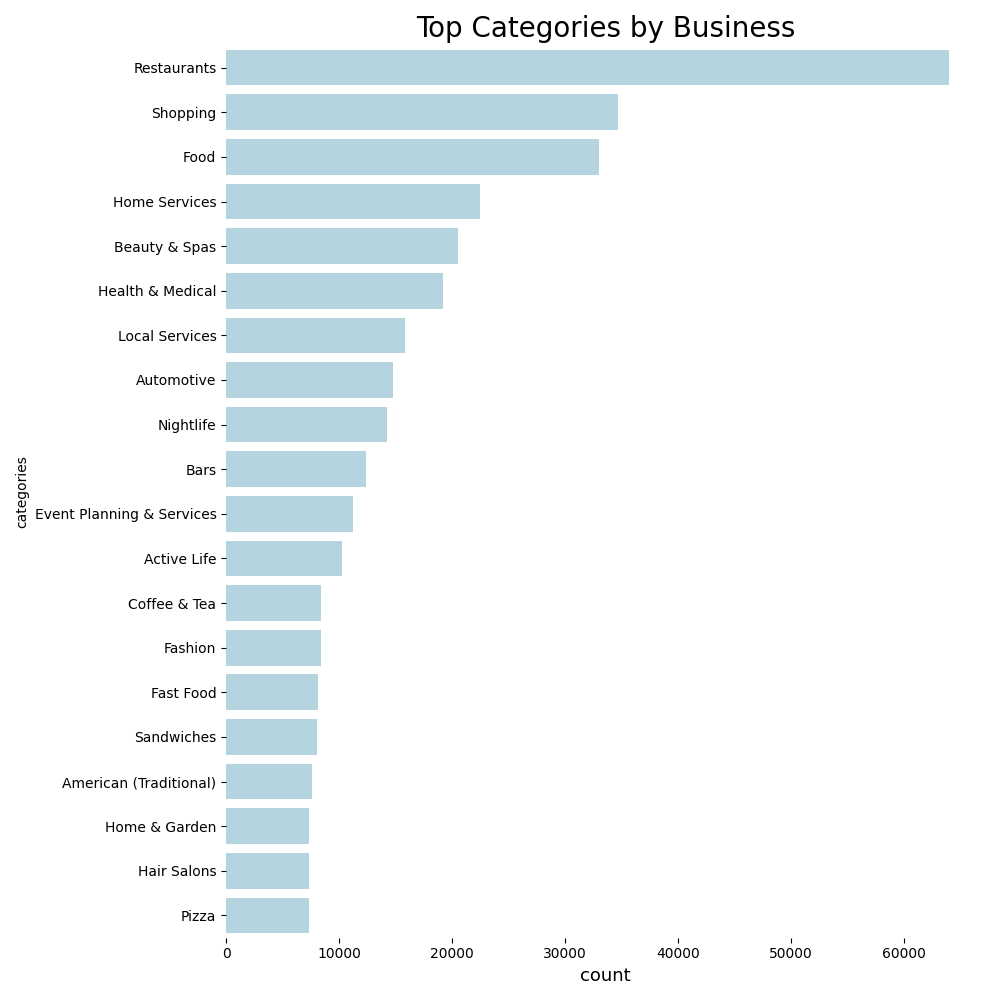

In [18]:
top = x1.select('categories').groupby(x1.categories).count().sort(desc("count")).limit(20).toPandas()

plt.clf()
plt.figure(figsize=(10,10))
plt.title('Top Categories by Business', fontsize=20)
#plt.yticks(fontsize=12)
#plt.xticks(fontsize=12)
plt.xlabel('',fontsize=13)
plt.xlabel('category',fontsize=13)
plt.box(False)
plt.gca().invert_yaxis()
sb.barplot(top['count'],top['categories'],color="lightblue")
plt.tight_layout()
%matplot plt

# Do Yelp Reviews Skew Negative?

Oftentimes, it is said that the only people who write a written review are those who are extremely _dissatisfied_ or extremely _satisfied_ with the service received. 

How true is this really? Let's try and answer this question.

## Loading User Data

Begin by loading the user data set from S3 and printing schema to determine what data is available.

In [21]:
user_df = spark.read.json('s3://10yelpdata/*review.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
user_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

Let's begin by listing the `business_id` and `stars` columns together for the user reviews data.

In [24]:

user_df.select("business_id","stars").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|-MhfebM0QIsKt87iD...|  2.0|
|lbrU8StCq3yDfr-QM...|  1.0|
|HQl28KMwrEKHqhFrr...|  5.0|
|5JxlZaqCnk1MnbgRi...|  1.0|
|IS4cv902ykd8wj1TR...|  4.0|
+--------------------+-----+
only showing top 5 rows

Now, let's aggregate along the `stars` column to get a resultant dataframe that displays _average stars_ per business as accumulated by users who **took the time to submit a written review**.

In [47]:

from pyspark.sql.functions import col, avg
user_review = user_df.where(col("text").isNotNull()).groupby(user_df.business_id).agg(avg(col("stars")))
user_review.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|        avg(stars)|
+--------------------+------------------+
|ATeOjZzE3VOI-RW7F...| 3.433734939759036|
|RMjCnixEY5i12Ciqn...|3.5316455696202533|
|vbUABNAQI2iwN7v0x...|2.4545454545454546|
|VHsNB3pdGVcRgs6C3...| 3.411764705882353|
|r-W1HPIZ3V6S2DaXh...| 4.852459016393443|
+--------------------+------------------+
only showing top 5 rows

Now the fun part - let's join our two dataframes (reviews and business data) by `business_id`. 

In [48]:
from pyspark.sql.types import IntegerType, StringType, DoubleType
from pyspark.sql.functions import desc, udf, col

busi = user_df.groupby(user_df.business_id).agg(avg(col("stars")))
new_df1 = df.join(user_review, on=['business_id'])
new_df2= df.join(busi,on=['business_id'])
new_df1.select("""avg(stars)""","stars","name","city","state").sort(desc("""avg(stars)""")).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+--------------------+---------------+-----+
|avg(stars)|stars|                name|           city|state|
+----------+-----+--------------------+---------------+-----+
|       5.0|  5.0|Diamond Finish De...|      Avon Lake|   OH|
|       5.0|  5.0|DB Mobile Notary ...|      Las Vegas|   NV|
|       5.0|  5.0|         Xoxo Lashes|North Las Vegas|   NV|
|       5.0|  5.0|          Econolight|        Phoenix|   AZ|
|       5.0|  5.0|         Beezy Booth|         Peoria|   AZ|
+----------+-----+--------------------+---------------+-----+
only showing top 5 rows

Let's see a few of these:

Compute a new dataframe that calculates what we will call the _skew_ (for lack of a better word) between the avg stars accumulated from written reviews and the _actual_ star rating of a business (ie: the average of stars given by reviewers who wrote an actual review **and** reviewers who just provided a star rating).

The formula you can use is something like:

```
(row['avg(stars)'] - row['stars']) / row['stars']
```

If the **skew** is negative, we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. If **skew** is positive, we can interpret that to be: reviewers who left a written response were more satisfied than normal.

In [49]:
x = new_df1.select("avg(stars)","stars","name","city","state").sort("""avg(stars)""",ascending=False)
y =   new_df2.select("avg(stars)","stars","name","city","state").sort("""avg(stars)""",ascending=False)
new_x = x.withColumn("skew", ((x["""avg(stars)"""]-y["stars"])/x["stars"])).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

And finally, graph it!

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

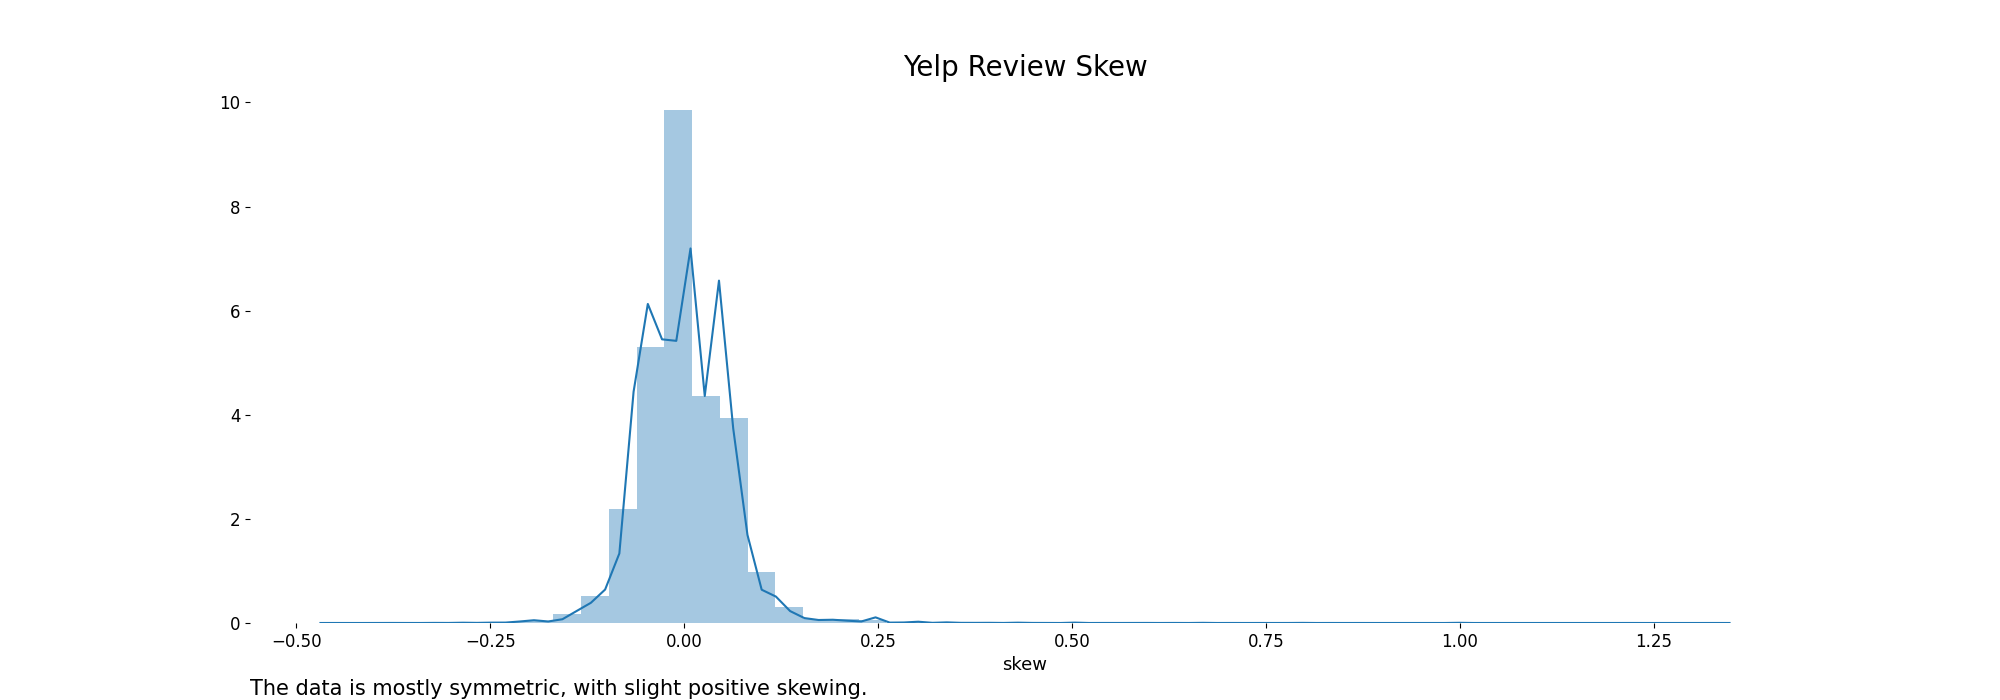

In [30]:
plt.clf()
plt.figure(figsize=(20,7))
plt.title('Yelp Review Skew', fontsize=20)

plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('',fontsize=13)
plt.box(False)
hist_kws=dict(alpha=0.2)
sb.distplot(new_x["skew"])
plt.annotate("The data is mostly symmetric, with slight positive skewing.",(0,0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top',fontsize=15)
%matplot plt

So, do Yelp (written) Reviews skew negative? Does this analysis actually prove anything? Expound on implications / interpretations of this graph. 

# Should the Elite be Trusted? (Or, some other analysis of your choice)

For the final portion - you have a choice:

* Try and analyze some interesting dimension to this data. The **ONLY** requirement is that you must use the **Users** dataset and join on either the **business* or **reviews** dataset
* Or, you may try and answer the question posed: how accurate or close are the ratings of an "elite" user (check Users table schema) vs the actual business rating.

Feel free to use any and all methodologies at your disposal - only requirement is you must render one visualization in your analysis

### Load User Data and Review Data

In [31]:
users = spark.read.json('s3://10yelpdata/*user.json')
reviews = spark.read.json('s3://10yelpdata/*review.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
users.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

In [37]:
reviews.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

In [36]:
users.select('user_id','elite','useful').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+------+
|             user_id|               elite|useful|
+--------------------+--------------------+------+
|ntlvfPzc8eglqvk92...|                    |   628|
|FOBRPlBHa3WPHFB5q...|2008,2009,2010,20...|   790|
|zZUnPeh2hEp0WydbA...|                2010|   151|
|QaELAmRcDc5TfJEyl...|                2009|   233|
|xvu8G900tezTzbbfq...|2009,2010,2011,20...|  1265|
+--------------------+--------------------+------+
only showing top 5 rows

### Join User with Review

In [50]:
user_join_review = reviews.join(users, on = "user_id")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Split Elite column

In [54]:
temp = user_join_review.select(col("user_id"), explode(split(col("elite"),",")).alias('elite'))
temp.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|             user_id|elite|
+--------------------+-----+
|-0Ji0nOyFe-4yo8BK...|     |
|-0XPr1ilUAfp-yIXZ...|     |
|-1KKYzibGPyUX-Mwk...| 2011|
|-1KKYzibGPyUX-Mwk...| 2012|
|-1KKYzibGPyUX-Mwk...| 2013|
+--------------------+-----+
only showing top 5 rows

In [56]:
temp = temp.withColumn('elite', temp.elite.cast(IntegerType()))
temp.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|             user_id|elite|
+--------------------+-----+
|-0Ji0nOyFe-4yo8BK...| null|
|-0XPr1ilUAfp-yIXZ...| null|
|-1KKYzibGPyUX-Mwk...| 2011|
|-1KKYzibGPyUX-Mwk...| 2012|
|-1KKYzibGPyUX-Mwk...| 2013|
+--------------------+-----+
only showing top 5 rows

In [93]:
temp_join = temp.join(reviews, on = ['user_id'], how = 'outer')
temp_join.select("user_id","elite","useful","stars").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+------+-----+
|             user_id|elite|useful|stars|
+--------------------+-----+------+-----+
|-0Ji0nOyFe-4yo8BK...| null|     0|  4.0|
|-0XPr1ilUAfp-yIXZ...| null|     1|  2.0|
|-1KKYzibGPyUX-Mwk...| 2011|     1|  4.0|
|-1KKYzibGPyUX-Mwk...| 2012|     1|  4.0|
|-1KKYzibGPyUX-Mwk...| 2013|     1|  4.0|
+--------------------+-----+------+-----+
only showing top 5 rows

### Filter out elite and non elite

In [98]:
non_elite = temp_join.filter(temp_join.elite.isNull())
non_elite.select("user_id","elite","useful","stars").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+------+-----+
|             user_id|elite|useful|stars|
+--------------------+-----+------+-----+
|-0Ji0nOyFe-4yo8BK...| null|     0|  4.0|
|-0XPr1ilUAfp-yIXZ...| null|     1|  2.0|
|-1zQA2f_syMAdA04P...| null|     0|  5.0|
|-1zQA2f_syMAdA04P...| null|     0|  5.0|
|-1zQA2f_syMAdA04P...| null|     2|  1.0|
+--------------------+-----+------+-----+
only showing top 5 rows

In [99]:
elite = temp_join.filter(temp_join.elite.isNotNull())
elite.select("user_id","elite","useful","stars").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+------+-----+
|             user_id|elite|useful|stars|
+--------------------+-----+------+-----+
|-1KKYzibGPyUX-Mwk...| 2011|     1|  4.0|
|-1KKYzibGPyUX-Mwk...| 2012|     1|  4.0|
|-1KKYzibGPyUX-Mwk...| 2013|     1|  4.0|
|-1KKYzibGPyUX-Mwk...| 2014|     1|  4.0|
|-1KKYzibGPyUX-Mwk...| 2015|     1|  4.0|
+--------------------+-----+------+-----+
only showing top 5 rows

###  Calculate the average usefulnss of reviews

In [130]:
avg_useful_by_elite = elite.groupBy('stars').agg(mean('useful')).withColumnRenamed("avg(useful)", "elite")
avg_useful_by_elite.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+------------------+
|stars|             elite|
+-----+------------------+
|  1.0| 5.811115142496636|
|  4.0| 4.772969933332357|
|  3.0|3.9992882274469186|
|  2.0| 4.309098959771935|
|  5.0| 5.110927837555904|
+-----+------------------+

In [128]:
avg_useful_by_nonelite = non_elite.groupBy('stars').agg(mean('useful')).withColumnRenamed("avg(useful)", "none_elite")
avg_useful_by_nonelite.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+------------------+
|stars|        none_elite|
+-----+------------------+
|  1.0| 2.242308926095022|
|  4.0|1.2520172691253604|
|  3.0|1.1784644151510182|
|  2.0| 1.618597827472642|
|  5.0|1.2042220852566783|
+-----+------------------+

In [131]:
plot_df = avg_useful_by_elite.join(avg_useful_by_nonelite, on = ['stars'], how='inner').sort('stars')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [132]:
plot_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+------------------+------------------+
|stars|             elite|        none_elite|
+-----+------------------+------------------+
|  1.0| 5.811115142496636| 2.242308926095022|
|  2.0| 4.309098959771935| 1.618597827472642|
|  3.0|3.9992882274469186|1.1784644151510182|
|  4.0| 4.772969933332357|1.2520172691253604|
|  5.0| 5.110927837555904|1.2042220852566783|
+-----+------------------+------------------+

### convert Spark DataFrame into a Pandas DataFrame

In [133]:
plot_df_pd = plot_df.toPandas()
plot_df_pd.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   stars     elite  none_elite
0    1.0  5.811115    2.242309
1    2.0  4.309099    1.618598
2    3.0  3.999288    1.178464
3    4.0  4.772970    1.252017
4    5.0  5.110928    1.204222

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

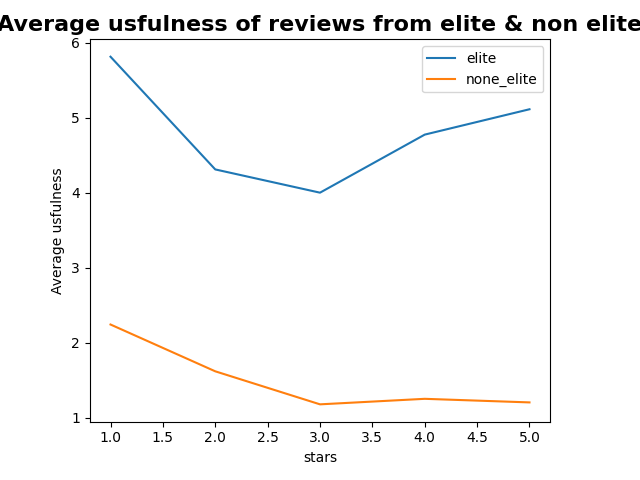

In [135]:
plt.figure()

ax = plot_df_pd.set_index('stars').plot()

ax.set_ylabel('Average usfulness')

ax.set_xlabel('stars')

plt.title("Average usfulness of reviews from elite & non elite", weight='bold', size=16)

plt.tight_layout()

%matplot plt

From the chart above, we can clearly see that elites' reviews are munch more than those from who are not.